In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from scipy.stats import pearsonr

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [67]:
def load_data(dates):
    dataframes = {}
    for date in dates:
        for asset in ['QQQ', 'SPY', 'FAST', 'MRVL', 'VRSK', 'VXX', 'ANSS']:
            dataframe = pd.read_parquet(f'C:/Users/Эвелина Новикова/{asset}_{date}.parquet')
            dataframe["datetime"] = pd.to_datetime(dataframe["ts"], unit="ns", utc=True)
            dataframe = dataframe.set_index("datetime")
            dataframe[f'mid_{asset}'] = (dataframe['bids[0].price'] + dataframe['asks[0].price'])/2
            dataframe[f'log_ret_{asset}'] = np.log(dataframe[f'mid_{asset}']).diff().fillna(1e-8)
            dataframes[f'{asset}_{date}'] = pd.DataFrame({f'mid_{asset}': dataframe[f'mid_{asset}'],
                                                          f'log_ret_{asset}': dataframe[f'log_ret_{asset}']}).resample("100ms").agg('mean').ffill()
 
    return dataframes

In [69]:
dates = [20250630, 20250701, 20250702, 20250703]
dataframes = load_data(dates)

In [73]:
def make_combined_df(date):
    combined_df = dataframes[f'VXX_{date}'].join(dataframes[f'SPY_{date}'], how='inner')\
           .join(dataframes[f'QQQ_{date}'], how='inner')\
           .join(dataframes[f'MRVL_{date}'], how='inner')\
           .join(dataframes[f'ANSS_{date}'], how='inner')\
           .join(dataframes[f'FAST_{date}'], how='inner')\
           .join(dataframes[f'VRSK_{date}'], how='inner')
    return combined_df

In [75]:
combined_df_20250630 = make_combined_df(20250630)
combined_df_20250701 = make_combined_df(20250701)
combined_df_20250702 = make_combined_df(20250702)
combined_df_20250703 = make_combined_df(20250703)

### Основная торговая сессия (13:30 - 20:00)

In [81]:
def regular(combined_df):
    combined_df = combined_df.reset_index()
    combined_df['datetime'] = pd.to_datetime(combined_df['datetime'])
    filtered_df = combined_df[(combined_df['datetime'].dt.time >= pd.to_datetime('13:35:00').time()) 
                 & (combined_df['datetime'].dt.time < pd.to_datetime('19:55:00').time())]
    filtered_df = filtered_df.set_index('datetime')
    return filtered_df

In [83]:
regular_20250630 = regular(combined_df_20250630)
regular_20250701 = regular(combined_df_20250701)
regular_20250702 = regular(combined_df_20250702)
regular_20250703 = regular(combined_df_20250703)

In [85]:
regular_20250630.head()

,mid_VXX,log_ret_VXX,mid_SPY,log_ret_SPY,mid_QQQ,log_ret_QQQ,mid_MRVL,log_ret_MRVL,mid_ANSS,log_ret_ANSS,mid_FAST,log_ret_FAST,mid_VRSK,log_ret_VRSK
datetime,,,,,,,,,,,,,,
2025-06-30 13:35:00+00:00,47.855000,-0.000030,616.645,-0.000041,550.13,-0.000027,77.280526,-0.000007,349.5450,0.000000e+00,41.935000,0.000000,308.990,0.000000
2025-06-30 13:35:00.100000+00:00,47.855000,0.000000,616.670,0.000041,550.10,-0.000055,77.280000,0.000000,349.5825,8.940130e-07,41.951034,0.000025,308.865,-0.000202
2025-06-30 13:35:00.200000+00:00,47.855000,0.000000,616.635,-0.000057,550.12,0.000036,77.247449,-0.000001,349.5825,8.940130e-07,41.965000,0.000000,308.865,0.000000
2025-06-30 13:35:00.300000+00:00,47.856923,0.000008,616.635,0.000000,550.10,-0.000036,77.246585,0.000005,349.5825,8.940130e-07,41.960000,-0.000119,308.865,0.000000
2025-06-30 13:35:00.400000+00:00,47.860000,0.000000,616.645,0.000016,550.08,-0.000036,77.260000,0.000000,349.5825,8.940130e-07,41.945000,0.000000,308.865,0.000000


### Mid price

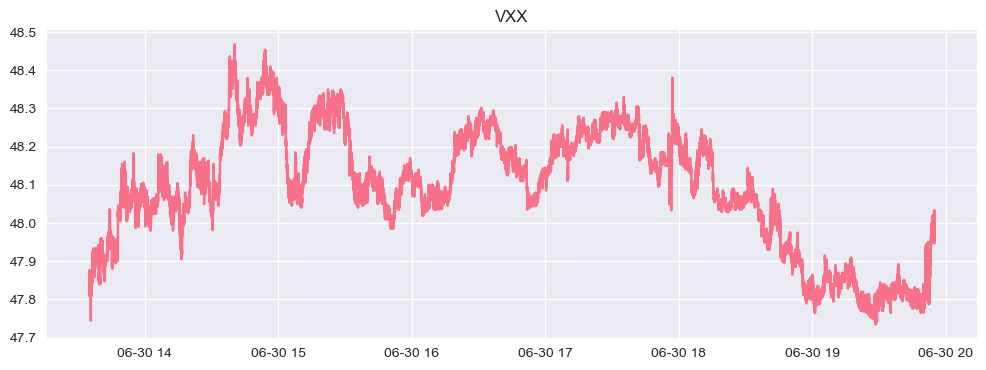

In [87]:
plt.figure(figsize=(12, 4))
plt.plot(regular_20250630['mid_VXX'])
plt.title('VXX')
plt.grid(True)
plt.show()

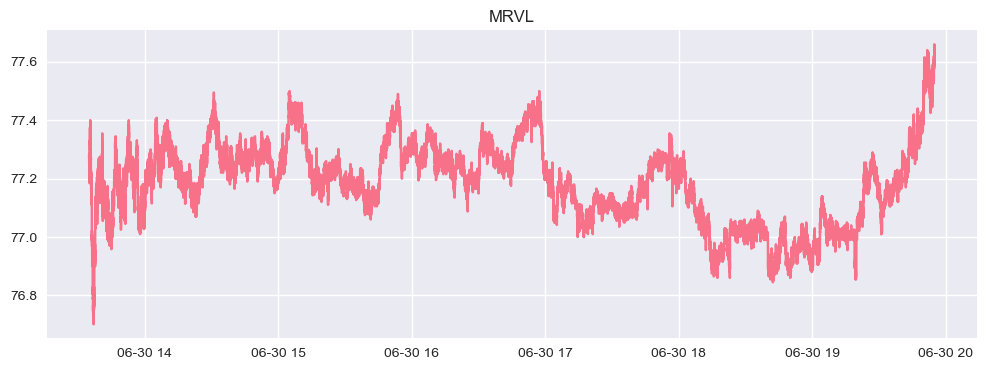

In [91]:
plt.figure(figsize=(12, 4))
plt.plot(regular_20250630['mid_MRVL'])
plt.title('MRVL')
plt.grid(True)
plt.show()

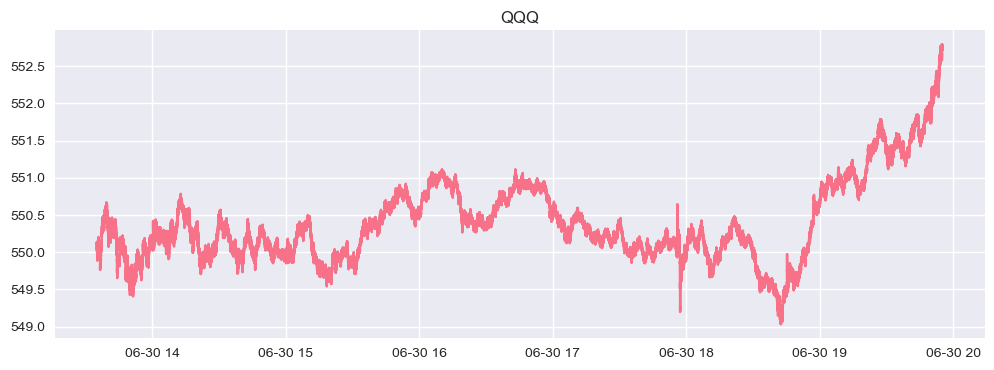

In [93]:
plt.figure(figsize=(12, 4))
plt.plot(regular_20250630['mid_QQQ'])
plt.title('QQQ')
plt.grid(True)
plt.show()

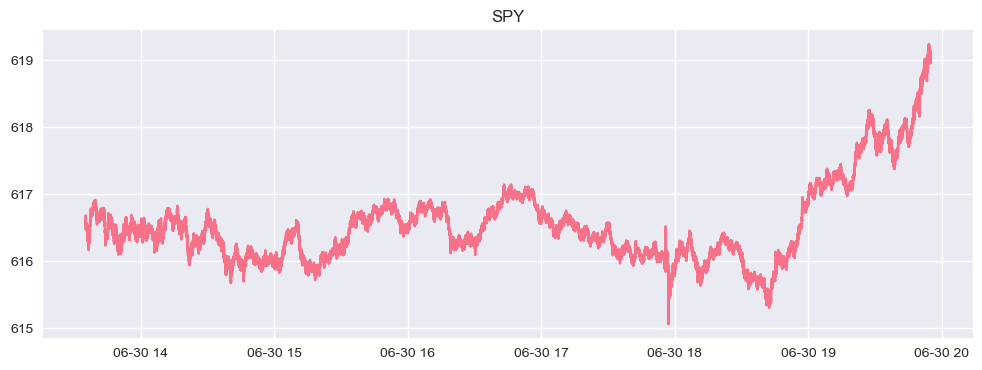

In [95]:
plt.figure(figsize=(12, 4))
plt.plot(regular_20250630['mid_SPY'])
plt.title('SPY')
plt.grid(True)
plt.show()

### Log returns

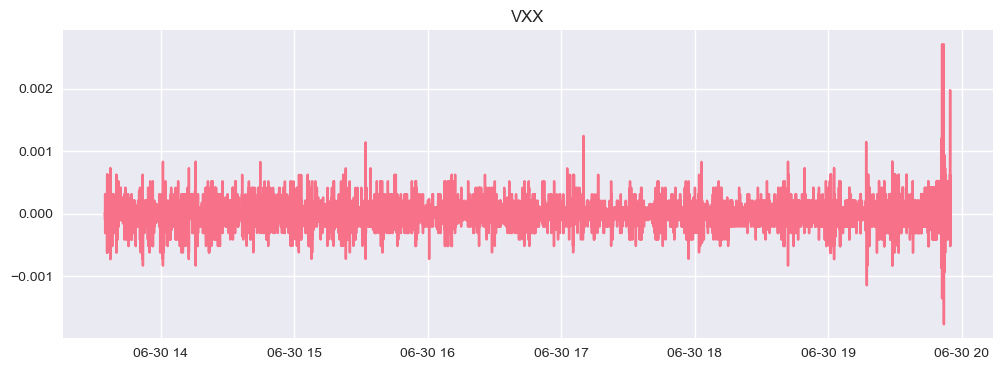

In [97]:
plt.figure(figsize=(12, 4))
plt.plot(regular_20250630['log_ret_VXX'])
plt.title('VXX')
plt.grid(True)
plt.show()

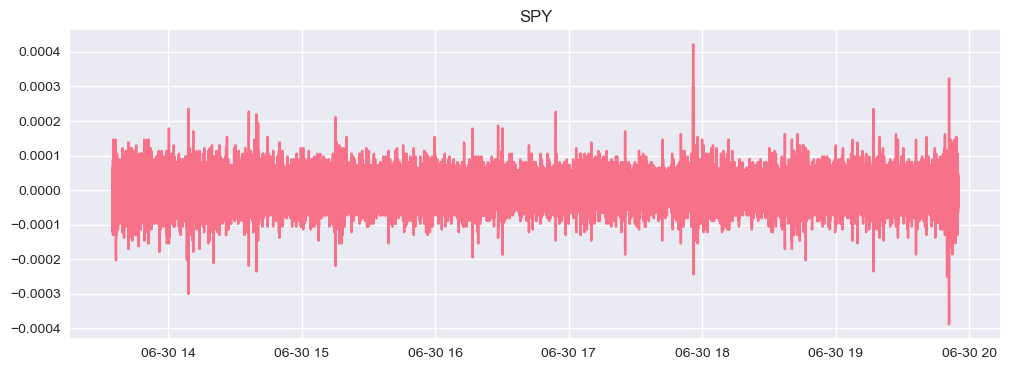

In [99]:
plt.figure(figsize=(12, 4))
plt.plot(regular_20250630['log_ret_SPY'])
plt.title('SPY')
plt.grid(True)
plt.show()

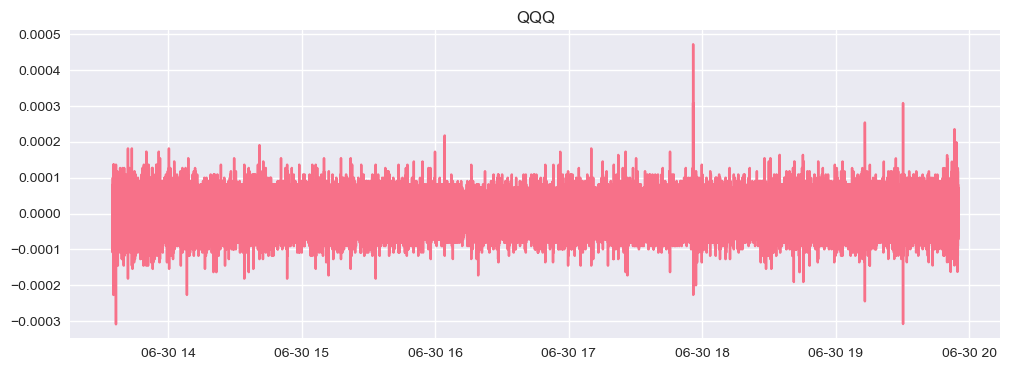

In [101]:
plt.figure(figsize=(12, 4))
plt.plot(regular_20250630['log_ret_QQQ'])
plt.title('QQQ')
plt.grid(True)
plt.show()

### Расчёт лаговых кросс-корреляций

Имеем выборку из 4 дней. Предварительно проводим анализ лаговых кросс-корреляций: лаг будет "кандидатом" на добавление в модель запаздывающего актива, если он при анализе всей выборки из 4 дней сохраняет направленность (если А следует за В, то ни разу не получается так, что В следует за А) и скачет в пределах 0 - 1,2 секунды.

In [104]:
max_lag_1 = 6000  # Максимальное количество лагов для анализа (100 мс - 10 мин)
results_1 = []

instruments_mid = ['mid_ANSS', 'mid_FAST', 'mid_VXX', 'mid_VRSK', 'mid_QQQ', 'mid_SPY', 'mid_MRVL']

In [106]:
def calculate_lagged_correlation(series1, series2, max_lag):
    lags = np.arange(-max_lag, max_lag + 1)
    correlations = []

    for lag in lags:
        if lag < 0:
            corr, _ = pearsonr(series1[:lag], series2[-lag:])
        elif lag > 0:
            corr, _ = pearsonr(series1[lag:], series2[:-lag])
        else:
            corr, _ = pearsonr(series1, series2)
        correlations.append(corr)

    best_lag = lags[np.argmax(np.abs(correlations))]
    best_correlation = correlations[np.argmax(np.abs(correlations))]
    return lags, correlations, best_lag, best_correlation

###  30.06

Вычисление корреляций: 100%|████████████████████████████████████████████████████████████| 7/7 [36:36<00:00, 313.76s/it]


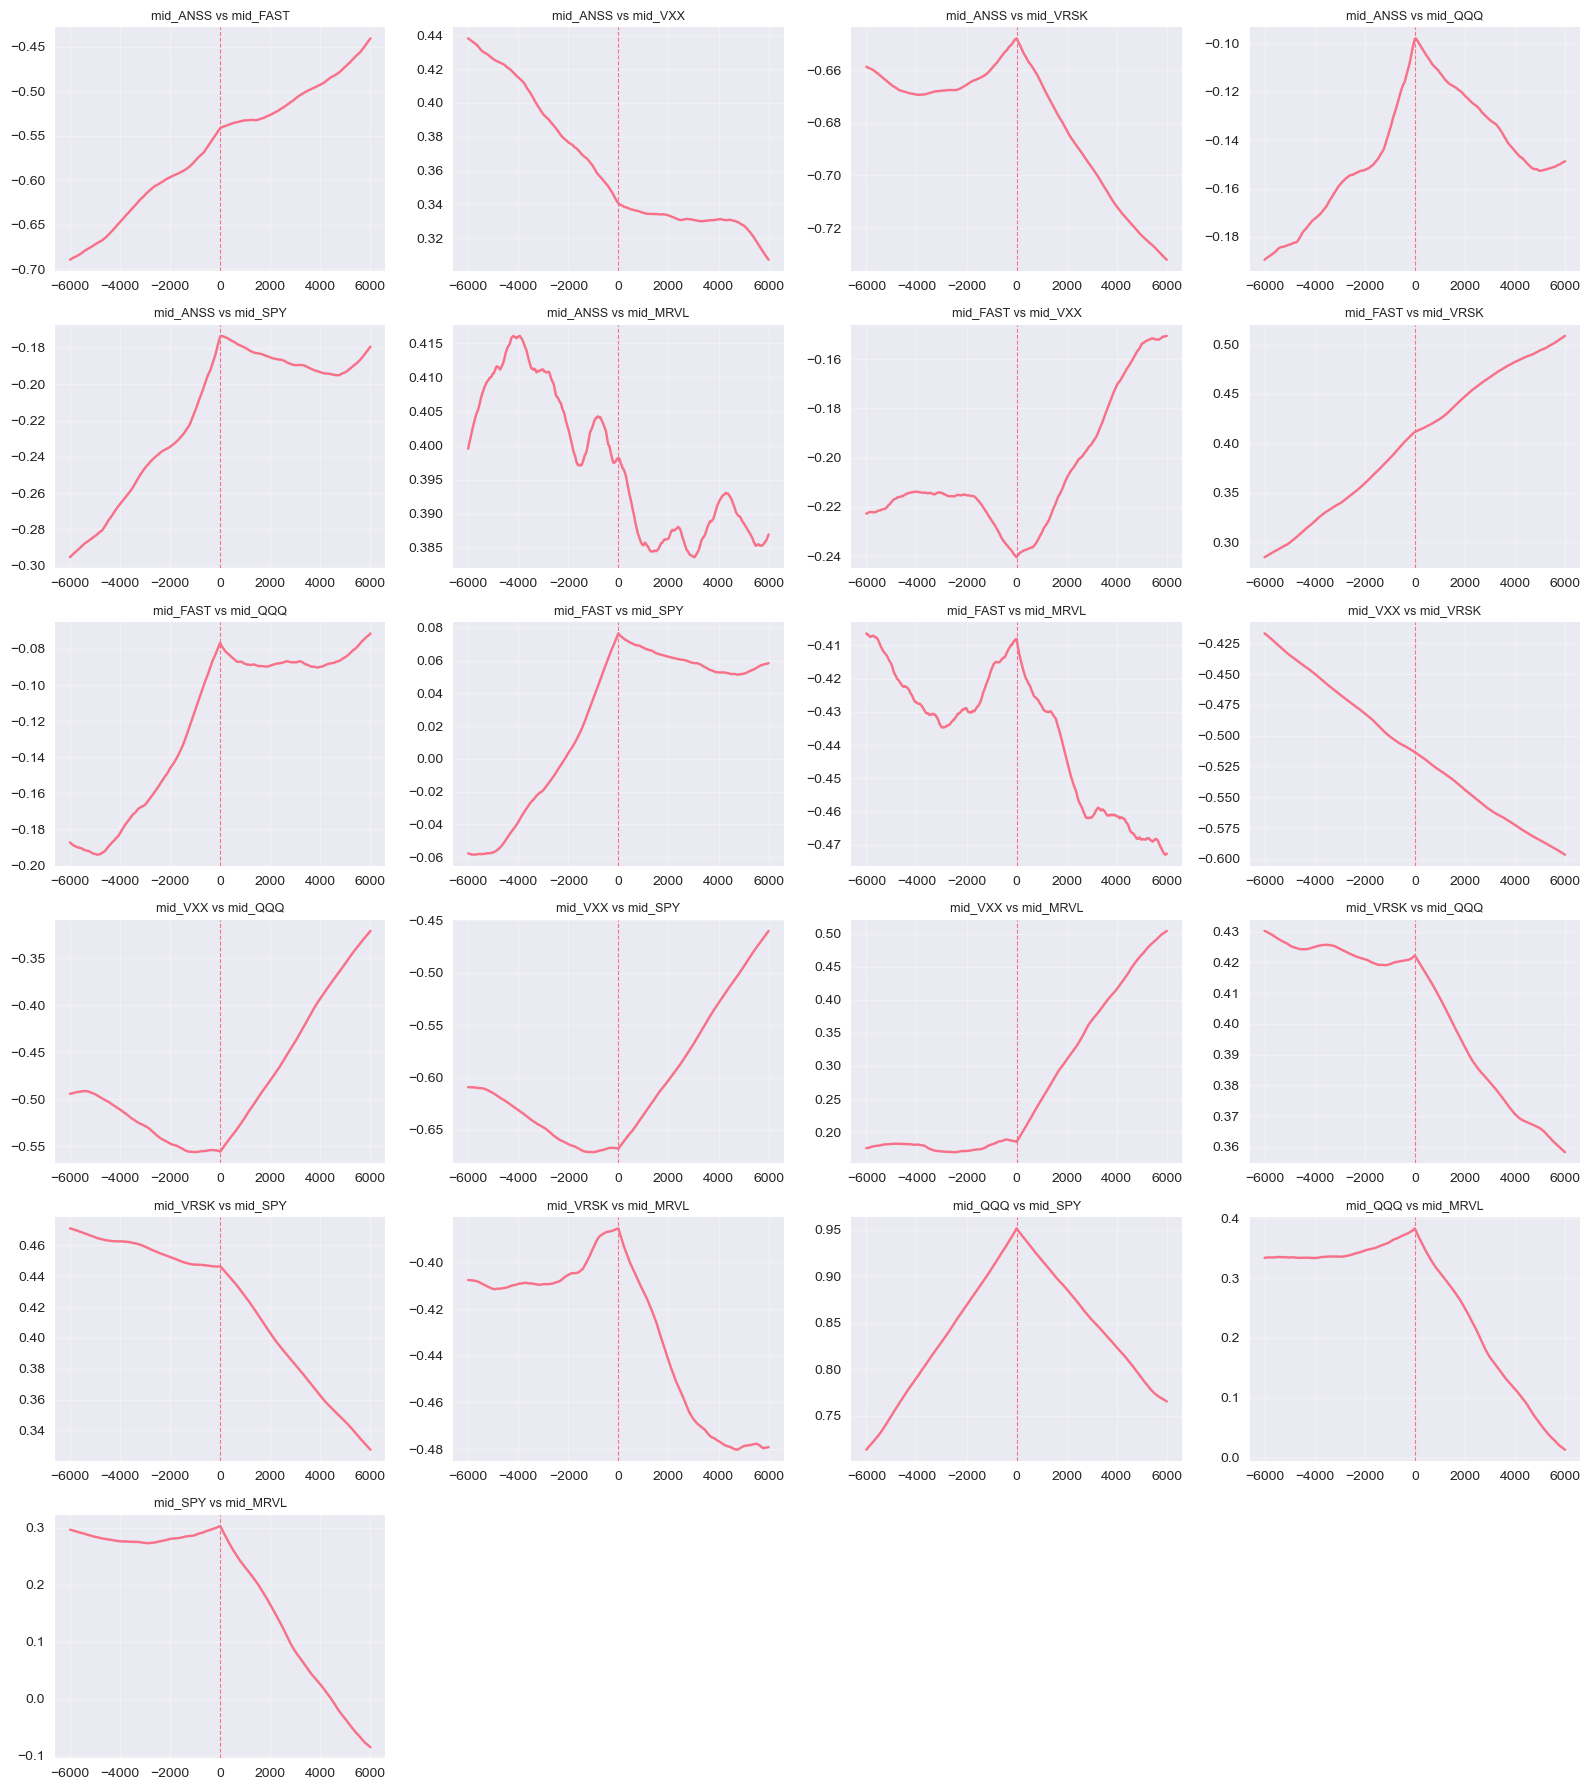

In [108]:
n = len(instruments_mid)
n_pairs = n * (n - 1) // 2

n_cols = 4
n_rows = math.ceil(n_pairs / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

plot_idx = 0

for i in tqdm(range(len(instruments_mid)), desc="Вычисление корреляций"):
    for j in range(i + 1, len(instruments_mid)):
        lags, correlations, best_lag, best_correlation = calculate_lagged_correlation(
            regular_20250630[instruments_mid[i]],
            regular_20250630[instruments_mid[j]],
            max_lag_1
        )

        results_1.append({
            'Instrument 1': instruments_mid[i],
            'Instrument 2': instruments_mid[j],
            'Best Lag': best_lag,
            'Best Correlation': best_correlation
        })

        ax = axes[plot_idx]
        ax.plot(lags, correlations)
        ax.set_title(f"{instruments_mid[i]} vs {instruments_mid[j]}", fontsize=9)
        ax.axvline(0, linestyle="--", linewidth=0.8)
        ax.grid(True, alpha=0.3)

        plot_idx += 1

for k in range(plot_idx, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()

In [110]:
results_1_df = pd.DataFrame(results_1)
print("Lag and Correlation between mid prices:")
print(results_1_df)

Lag and Correlation between mid prices:
   Instrument 1 Instrument 2  Best Lag  Best Correlation
0      mid_ANSS     mid_FAST     -6000         -0.689458
1      mid_ANSS      mid_VXX     -6000          0.438158
2      mid_ANSS     mid_VRSK      6000         -0.732035
3      mid_ANSS      mid_QQQ     -6000         -0.189396
4      mid_ANSS      mid_SPY     -6000         -0.295266
5      mid_ANSS     mid_MRVL     -3968          0.416070
6      mid_FAST      mid_VXX         0         -0.240477
7      mid_FAST     mid_VRSK      6000          0.508694
8      mid_FAST      mid_QQQ     -4906         -0.193990
9      mid_FAST      mid_SPY         0          0.076634
10     mid_FAST     mid_MRVL      5954         -0.472986
11      mid_VXX     mid_VRSK      6000         -0.596551
12      mid_VXX      mid_QQQ     -1013         -0.556373
13      mid_VXX      mid_SPY     -1014         -0.671217
14      mid_VXX     mid_MRVL      6000          0.504157
15     mid_VRSK      mid_QQQ     -6000          

In [112]:
G_1 = nx.DiGraph()
edge_labels_1 = {}


for _, row in results_1_df.iterrows():
    name1 = row['Instrument 1']
    name2 = row['Instrument 2']
    lag = row['Best Lag']
    correlation = row['Best Correlation']

    if lag < 0:
        G_1.add_edge(name2, name1)  
        edge_labels_1[(name2, name1)] = f'{correlation:.2f}'
    elif lag > 0:
        G_1.add_edge(name1, name2)  
        edge_labels_1[(name1, name2)] = f'{correlation:.2f}'

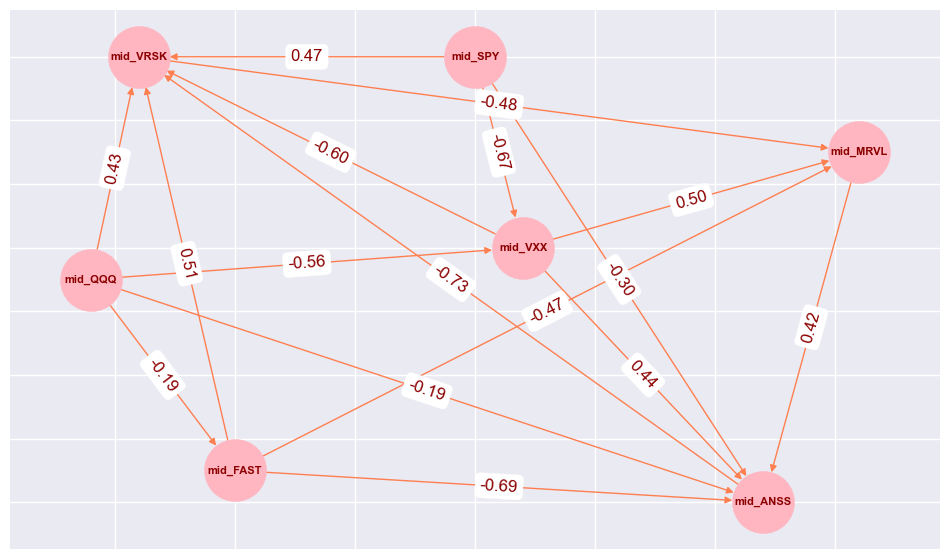

In [114]:
plt.figure(figsize=(12, 7))
node_color = 'lightpink'
edge_color = 'coral'    
font_color = 'darkred' 

fixed_positions_1 = {
    'mid_VXX': [0.1, 0.2],
    'mid_VRSK': [-0.7, 0.8],
    'mid_MRVL': [0.8, 0.5],
    'mid_FAST': [-0.5, -0.5],
    'mid_ANSS': [0.6, -0.6],
    'mid_SPY': [0.0, 0.8],
    'mid_QQQ': [-0.8, 0.1]
}

nx.draw_networkx(G_1, 
                 pos=fixed_positions_1, 
                 with_labels=True, 
                 node_size=2000, 
                 node_color=node_color,
                 edge_color=edge_color,
                 font_size=8, 
                 font_weight='bold',
                 font_color=font_color)

nx.draw_networkx_edge_labels(G_1, 
                             pos=fixed_positions_1, 
                             edge_labels=edge_labels_1, 
                             font_size=12, 
                             font_color='darkred')

plt.show()

### 01.07

In [120]:
results_2 = []

Вычисление корреляций: 100%|████████████████████████████████████████████████████████████| 7/7 [36:29<00:00, 312.80s/it]


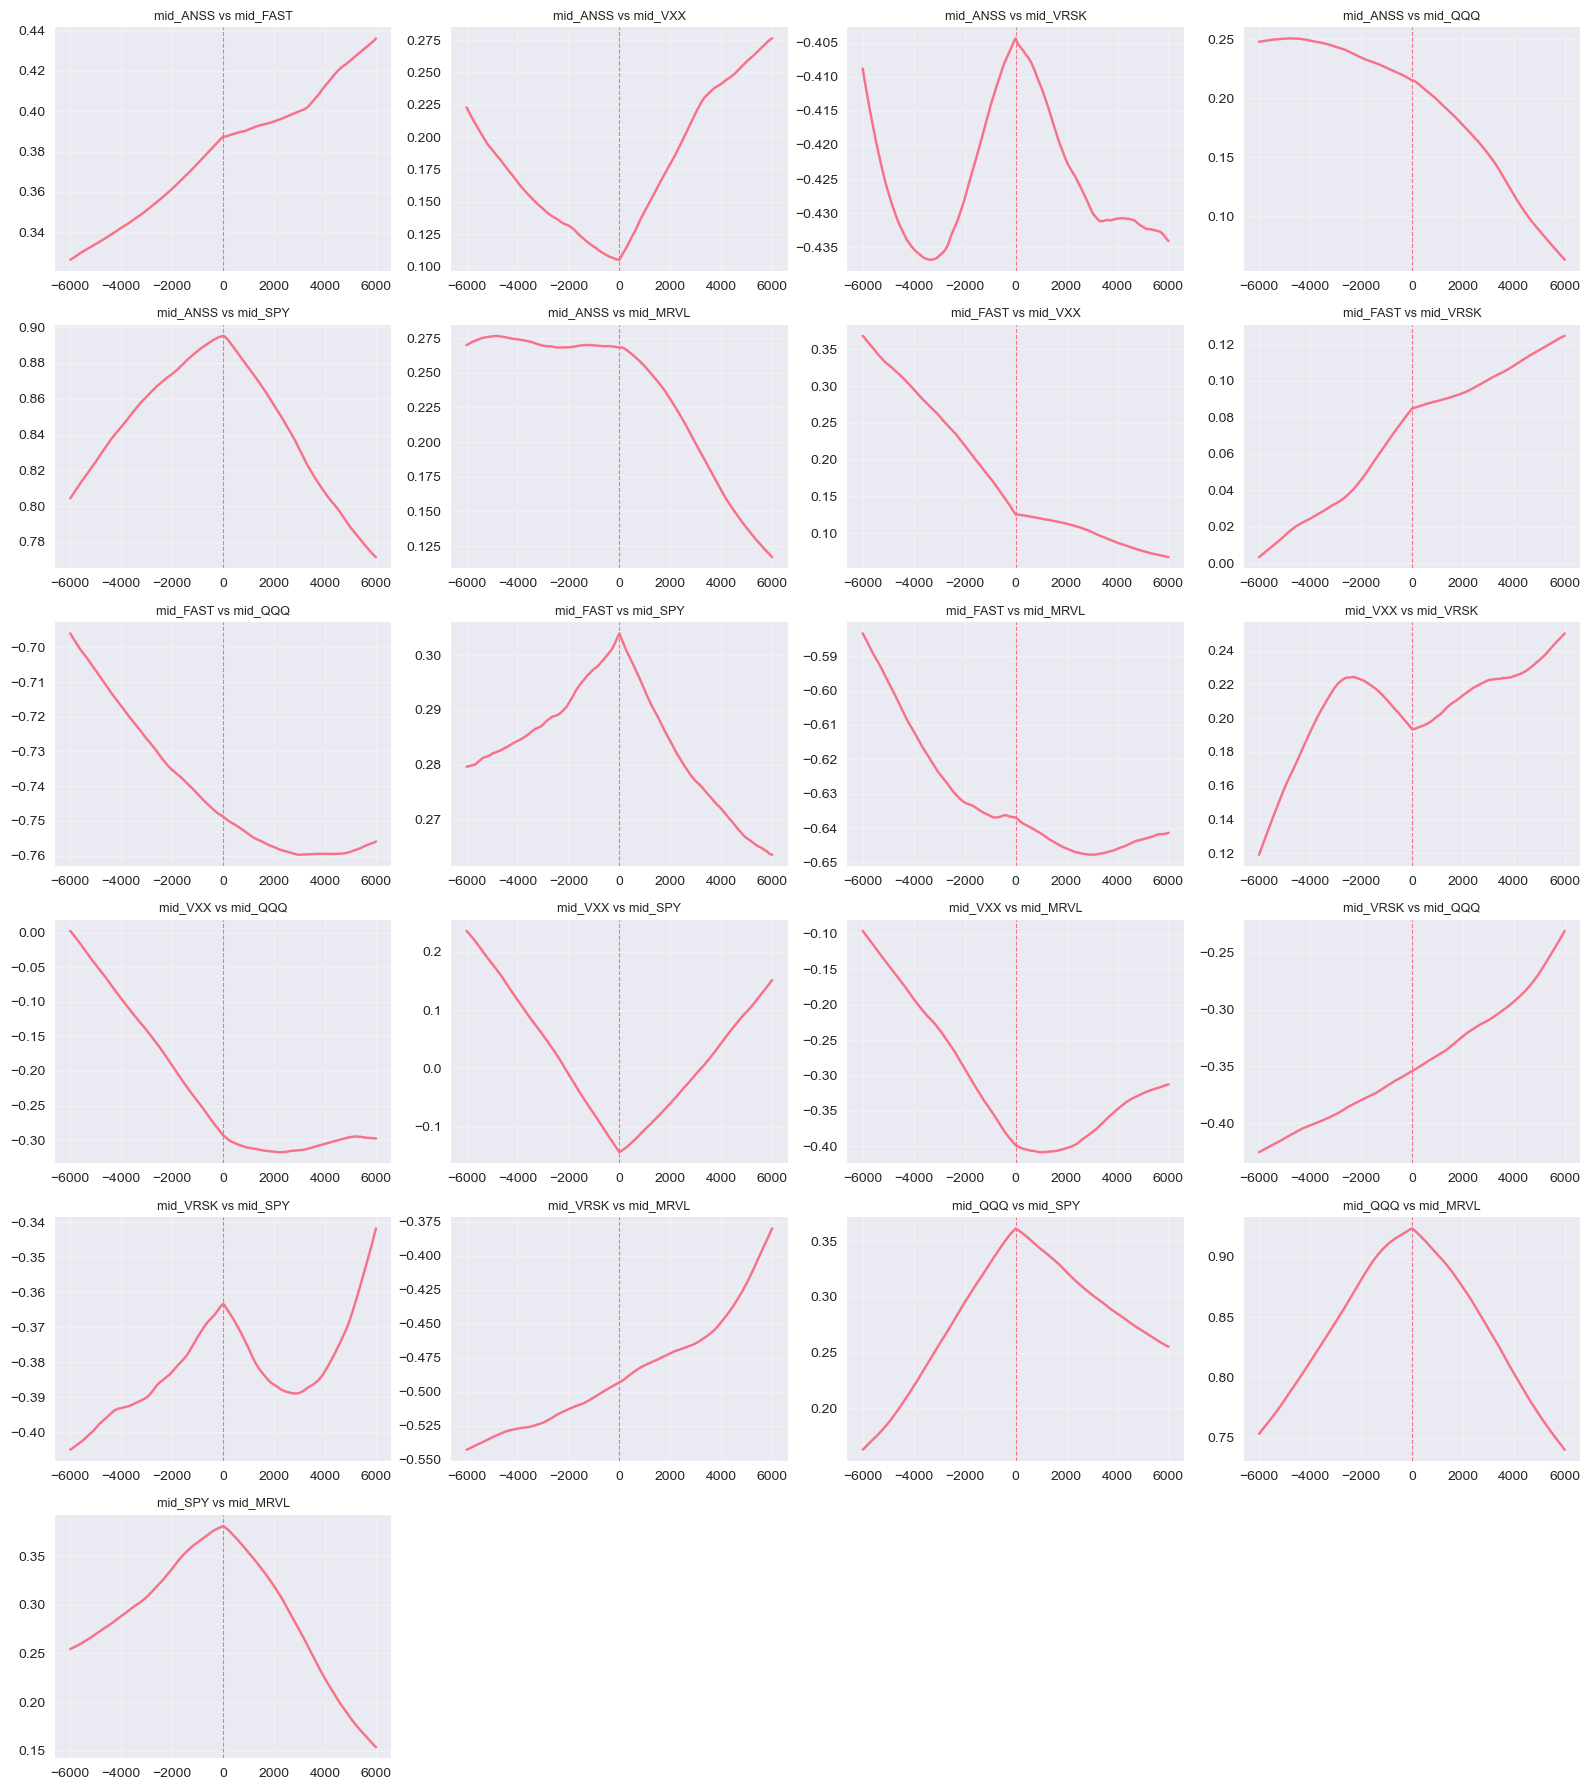

In [122]:
n = len(instruments_mid)
n_pairs = n * (n - 1) // 2

n_cols = 4
n_rows = math.ceil(n_pairs / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

plot_idx = 0

for i in tqdm(range(len(instruments_mid)), desc="Вычисление корреляций"):
    for j in range(i + 1, len(instruments_mid)):
        lags, correlations, best_lag, best_correlation = calculate_lagged_correlation(
            regular_20250701[instruments_mid[i]],
            regular_20250701[instruments_mid[j]],
            max_lag_1
        )

        results_2.append({
            'Instrument 1': instruments_mid[i],
            'Instrument 2': instruments_mid[j],
            'Best Lag': best_lag,
            'Best Correlation': best_correlation
        })

        ax = axes[plot_idx]
        ax.plot(lags, correlations)
        ax.set_title(f"{instruments_mid[i]} vs {instruments_mid[j]}", fontsize=9)
        ax.axvline(0, linestyle="--", linewidth=0.8)
        ax.grid(True, alpha=0.3)

        plot_idx += 1

for k in range(plot_idx, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()

In [123]:
results_2_df = pd.DataFrame(results_2)
print("Lag and Correlation between mid prices:")
print(results_2_df)

Lag and Correlation between mid prices:
   Instrument 1 Instrument 2  Best Lag  Best Correlation
0      mid_ANSS     mid_FAST      6000          0.436142
1      mid_ANSS      mid_VXX      6000          0.276283
2      mid_ANSS     mid_VRSK     -3319         -0.436809
3      mid_ANSS      mid_QQQ     -4808          0.250731
4      mid_ANSS      mid_SPY         2          0.895083
5      mid_ANSS     mid_MRVL     -4808          0.276663
6      mid_FAST      mid_VXX     -6000          0.368136
7      mid_FAST     mid_VRSK      6000          0.124733
8      mid_FAST      mid_QQQ      2989         -0.759757
9      mid_FAST      mid_SPY         0          0.303938
10     mid_FAST     mid_MRVL      2988         -0.647740
11      mid_VXX     mid_VRSK      6000          0.250222
12      mid_VXX      mid_QQQ      2249         -0.317407
13      mid_VXX      mid_SPY     -6000          0.235623
14      mid_VXX     mid_MRVL       952         -0.408227
15     mid_VRSK      mid_QQQ     -6000         -

In [124]:
G_2 = nx.DiGraph()
edge_labels_2 = {}


for _, row in results_2_df.iterrows():
    name1 = row['Instrument 1']
    name2 = row['Instrument 2']
    lag = row['Best Lag']
    correlation = row['Best Correlation']

    if lag < 0:
        G_2.add_edge(name2, name1)  
        edge_labels_2[(name2, name1)] = f'{correlation:.2f}'
    elif lag > 0:
        G_2.add_edge(name1, name2)  
        edge_labels_2[(name1, name2)] = f'{correlation:.2f}'

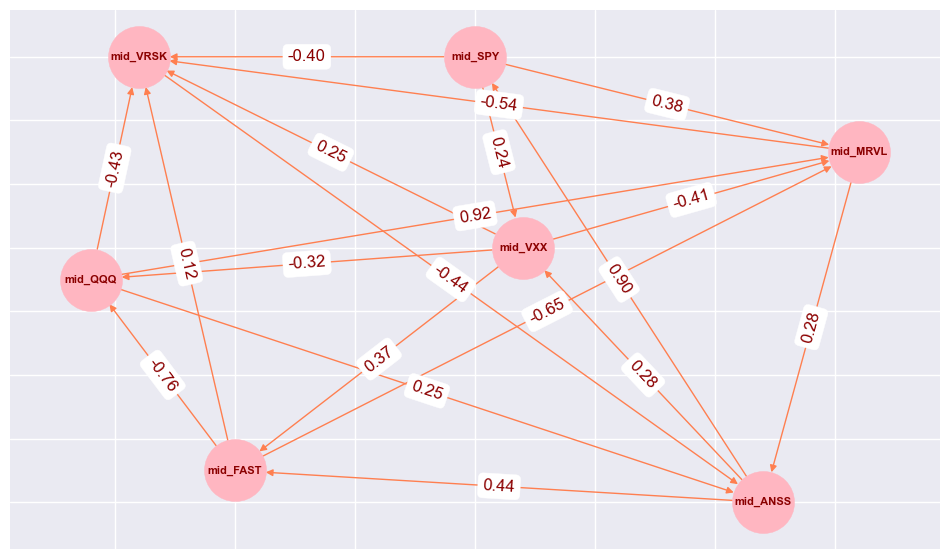

In [125]:
plt.figure(figsize=(12, 7))
node_color = 'lightpink'
edge_color = 'coral'    
font_color = 'darkred' 

fixed_positions_2 = {
    'mid_VXX': [0.1, 0.2],
    'mid_VRSK': [-0.7, 0.8],
    'mid_MRVL': [0.8, 0.5],
    'mid_FAST': [-0.5, -0.5],
    'mid_ANSS': [0.6, -0.6],
    'mid_SPY': [0.0, 0.8],
    'mid_QQQ': [-0.8, 0.1]
}

nx.draw_networkx(G_2, 
                 pos=fixed_positions_2, 
                 with_labels=True, 
                 node_size=2000, 
                 node_color=node_color,
                 edge_color=edge_color,
                 font_size=8, 
                 font_weight='bold',
                 font_color=font_color)

nx.draw_networkx_edge_labels(G_2, 
                             pos=fixed_positions_2, 
                             edge_labels=edge_labels_2, 
                             font_size=12, 
                             font_color='darkred')

plt.show()

### 02.07

In [126]:
results_3 = []

Вычисление корреляций: 100%|████████████████████████████████████████████████████████████| 7/7 [35:45<00:00, 306.53s/it]


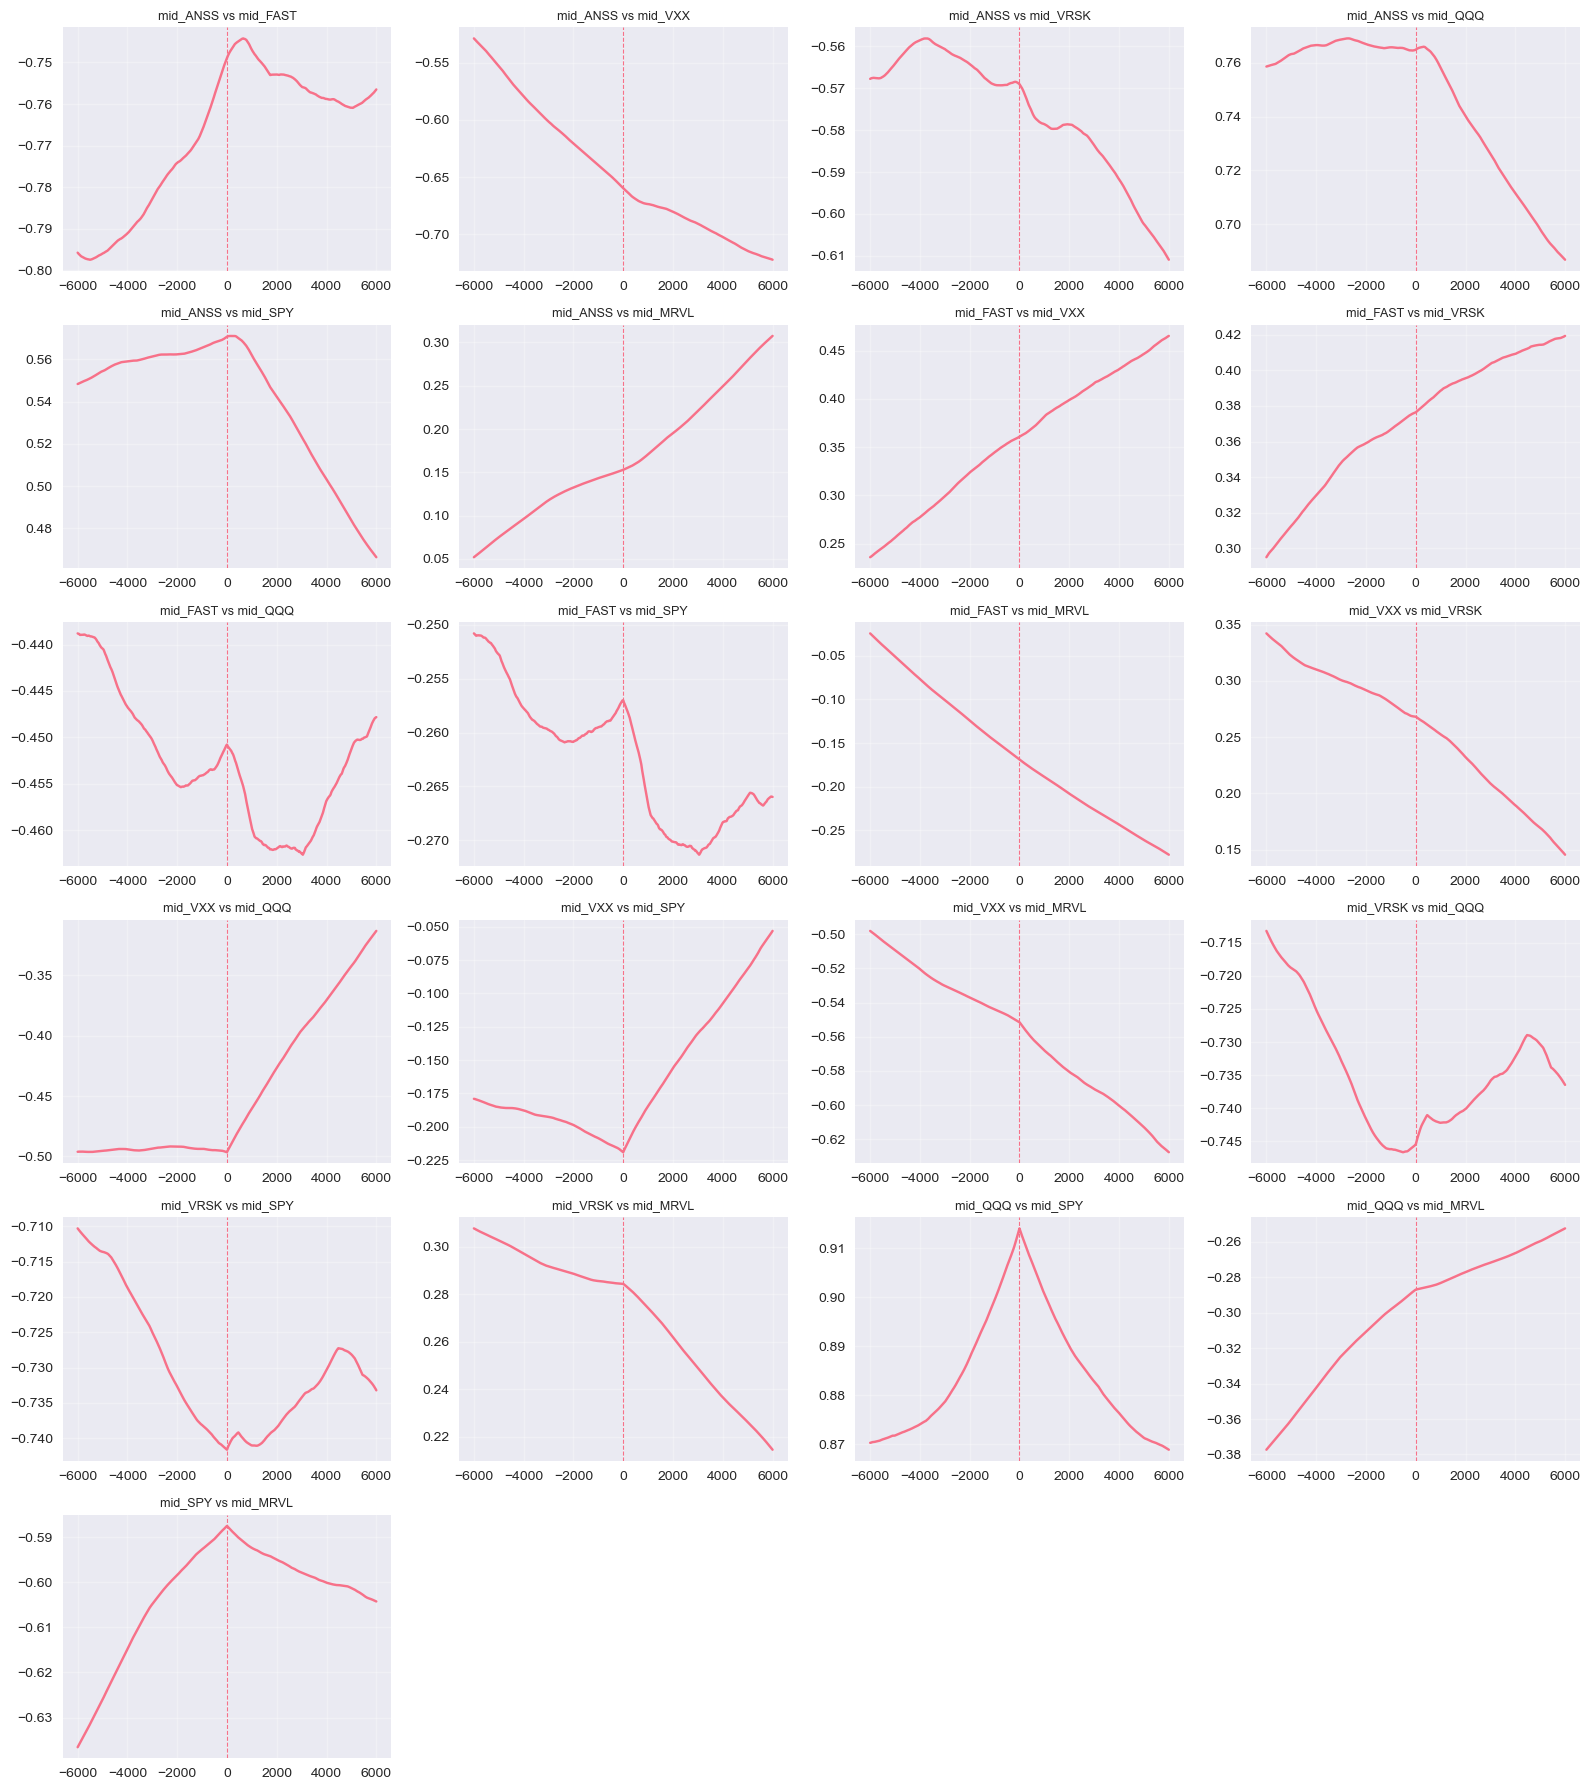

In [127]:
n = len(instruments_mid)
n_pairs = n * (n - 1) // 2

n_cols = 4
n_rows = math.ceil(n_pairs / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

plot_idx = 0

for i in tqdm(range(len(instruments_mid)), desc="Вычисление корреляций"):
    for j in range(i + 1, len(instruments_mid)):
        lags, correlations, best_lag, best_correlation = calculate_lagged_correlation(
            regular_20250702[instruments_mid[i]],
            regular_20250702[instruments_mid[j]],
            max_lag_1
        )

        results_3.append({
            'Instrument 1': instruments_mid[i],
            'Instrument 2': instruments_mid[j],
            'Best Lag': best_lag,
            'Best Correlation': best_correlation
        })

        ax = axes[plot_idx]
        ax.plot(lags, correlations)
        ax.set_title(f"{instruments_mid[i]} vs {instruments_mid[j]}", fontsize=9)
        ax.axvline(0, linestyle="--", linewidth=0.8)
        ax.grid(True, alpha=0.3)

        plot_idx += 1

for k in range(plot_idx, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()

In [128]:
results_3_df = pd.DataFrame(results_3)
print("Lag and Correlation between mid prices:")
print(results_3_df)

Lag and Correlation between mid prices:
   Instrument 1 Instrument 2  Best Lag  Best Correlation
0      mid_ANSS     mid_FAST     -5505         -0.797447
1      mid_ANSS      mid_VXX      6000         -0.722248
2      mid_ANSS     mid_VRSK      6000         -0.610921
3      mid_ANSS      mid_QQQ     -2702          0.769076
4      mid_ANSS      mid_SPY       256          0.571029
5      mid_ANSS     mid_MRVL      6000          0.307466
6      mid_FAST      mid_VXX      6000          0.465282
7      mid_FAST     mid_VRSK      6000          0.419326
8      mid_FAST      mid_QQQ      3047         -0.462660
9      mid_FAST      mid_SPY      3047         -0.271341
10     mid_FAST     mid_MRVL      6000         -0.277848
11      mid_VXX     mid_VRSK     -6000          0.342313
12      mid_VXX      mid_QQQ        -1         -0.496510
13      mid_VXX      mid_SPY        -1         -0.219111
14      mid_VXX     mid_MRVL      6000         -0.627634
15     mid_VRSK      mid_QQQ      -513         -

In [129]:
G_3 = nx.DiGraph()
edge_labels_3 = {}


for _, row in results_3_df.iterrows():
    name1 = row['Instrument 1']
    name2 = row['Instrument 2']
    lag = row['Best Lag']
    correlation = row['Best Correlation']

    if lag < 0:
        G_3.add_edge(name2, name1)  
        edge_labels_3[(name2, name1)] = f'{correlation:.2f}'
    elif lag > 0:
        G_3.add_edge(name1, name2)  
        edge_labels_3[(name1, name2)] = f'{correlation:.2f}'

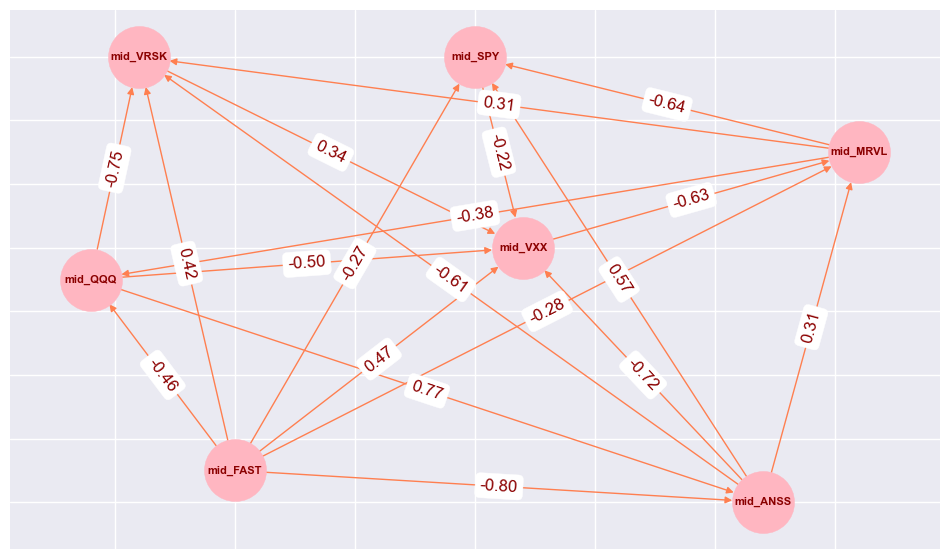

In [130]:
plt.figure(figsize=(12, 7))
node_color = 'lightpink'
edge_color = 'coral'    
font_color = 'darkred' 

fixed_positions_3 = {
    'mid_VXX': [0.1, 0.2],
    'mid_VRSK': [-0.7, 0.8],
    'mid_MRVL': [0.8, 0.5],
    'mid_FAST': [-0.5, -0.5],
    'mid_ANSS': [0.6, -0.6],
    'mid_SPY': [0.0, 0.8],
    'mid_QQQ': [-0.8, 0.1]
}

nx.draw_networkx(G_3, 
                 pos=fixed_positions_3, 
                 with_labels=True, 
                 node_size=2000, 
                 node_color=node_color,
                 edge_color=edge_color,
                 font_size=8, 
                 font_weight='bold',
                 font_color=font_color)

nx.draw_networkx_edge_labels(G_3, 
                             pos=fixed_positions_3, 
                             edge_labels=edge_labels_3, 
                             font_size=12, 
                             font_color='darkred')

plt.show()

### 03.07

In [131]:
results_4 = []

Вычисление корреляций: 100%|████████████████████████████████████████████████████████████| 7/7 [34:58<00:00, 299.72s/it]


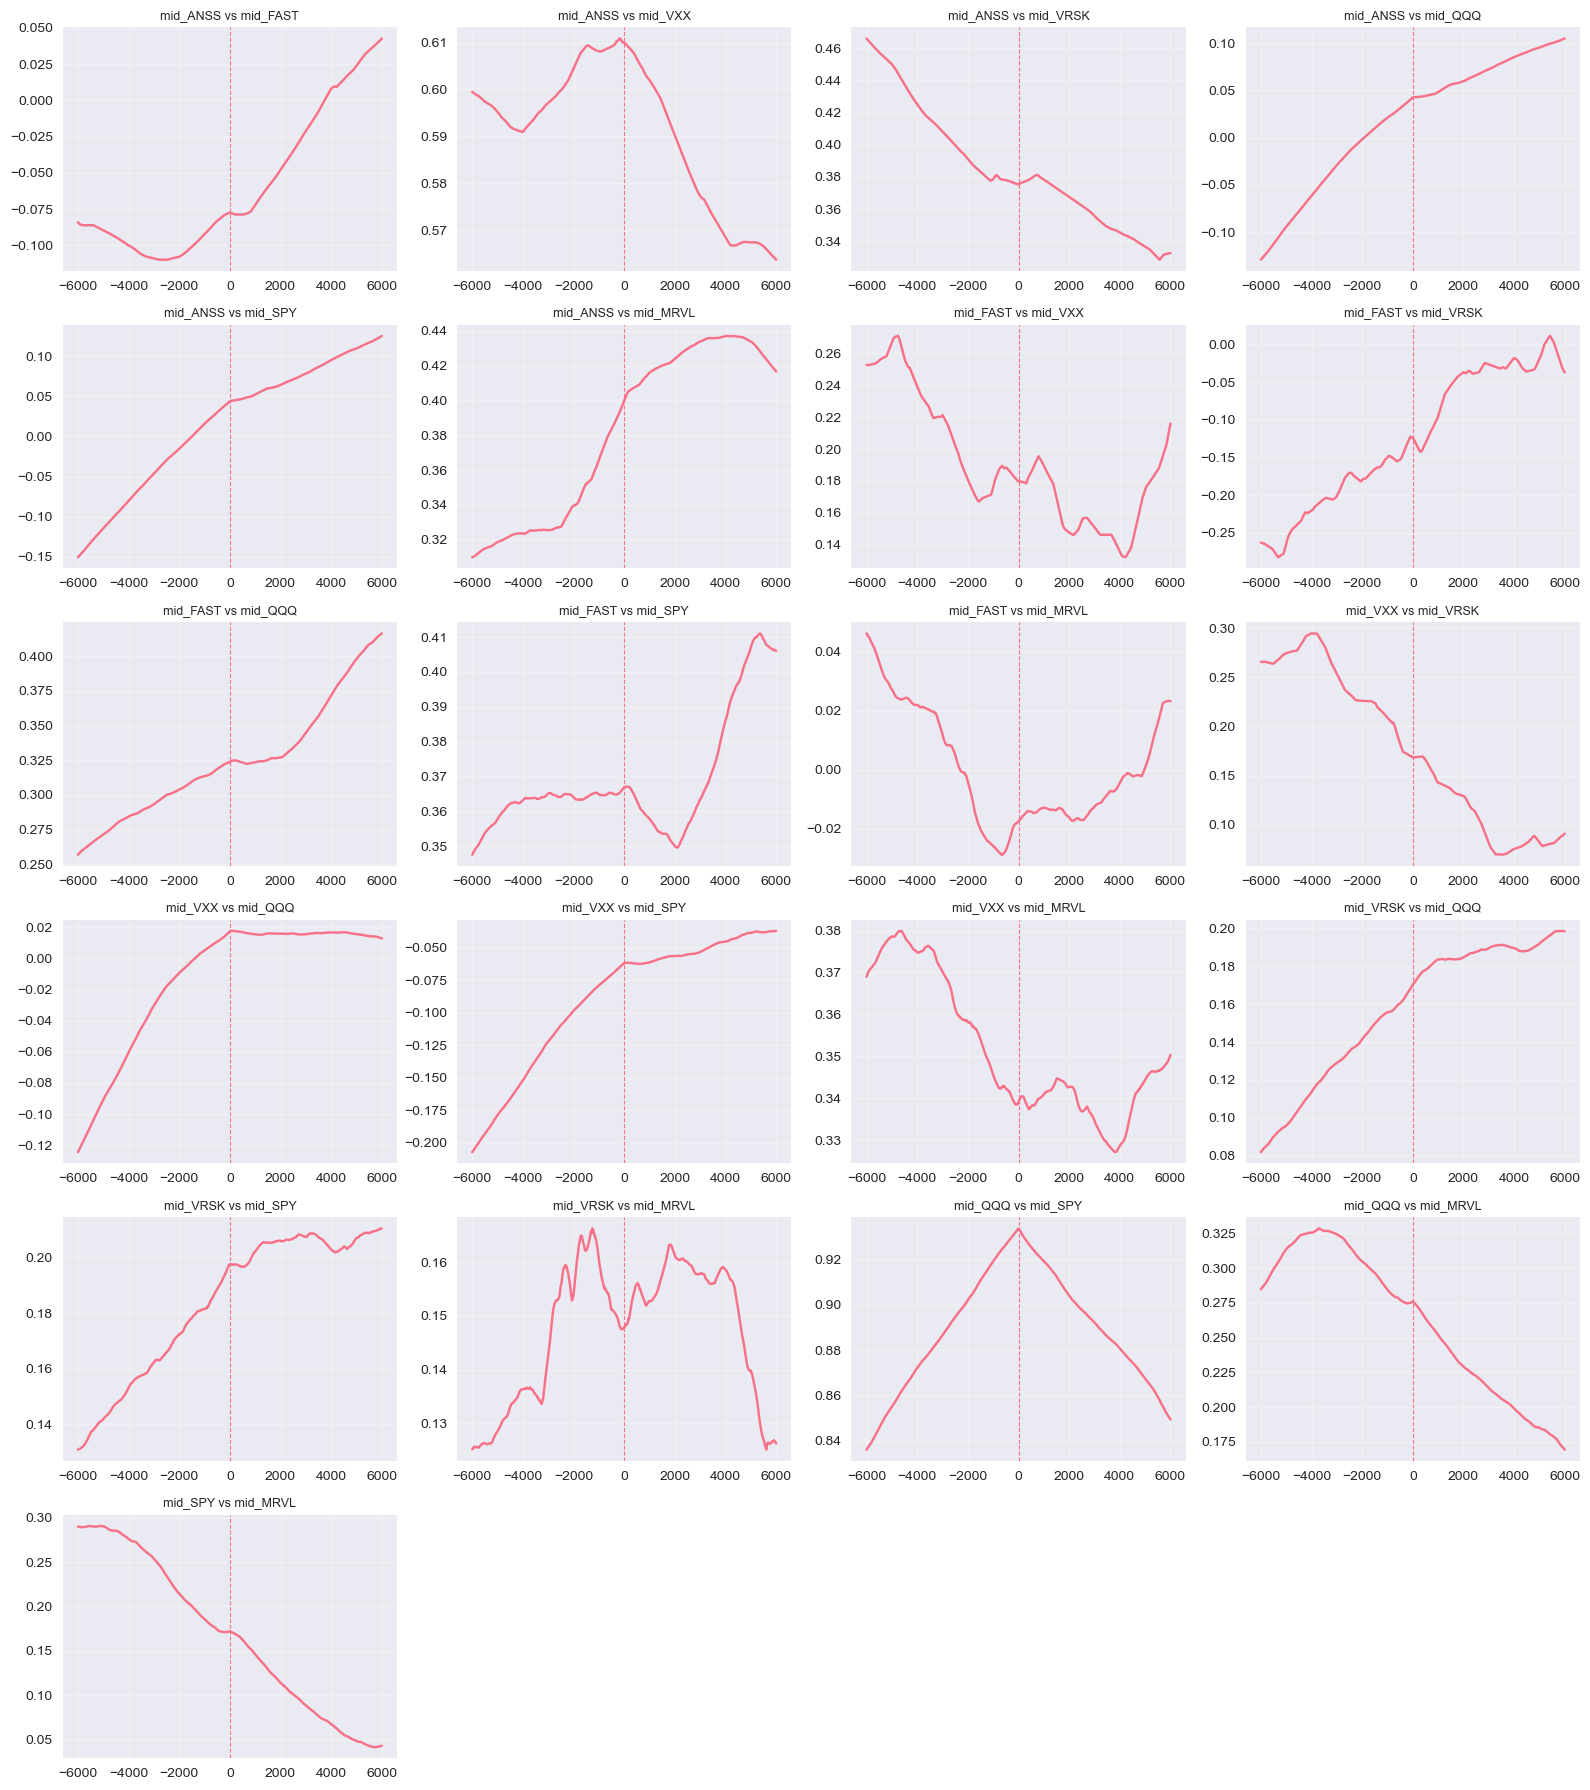

In [132]:
n = len(instruments_mid)
n_pairs = n * (n - 1) // 2

n_cols = 4
n_rows = math.ceil(n_pairs / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

plot_idx = 0

for i in tqdm(range(len(instruments_mid)), desc="Вычисление корреляций"):
    for j in range(i + 1, len(instruments_mid)):
        lags, correlations, best_lag, best_correlation = calculate_lagged_correlation(
            regular_20250703[instruments_mid[i]],
            regular_20250703[instruments_mid[j]],
            max_lag_1
        )

        results_4.append({
            'Instrument 1': instruments_mid[i],
            'Instrument 2': instruments_mid[j],
            'Best Lag': best_lag,
            'Best Correlation': best_correlation
        })

        ax = axes[plot_idx]
        ax.plot(lags, correlations)
        ax.set_title(f"{instruments_mid[i]} vs {instruments_mid[j]}", fontsize=9)
        ax.axvline(0, linestyle="--", linewidth=0.8)
        ax.grid(True, alpha=0.3)

        plot_idx += 1

for k in range(plot_idx, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()

In [133]:
results_4_df = pd.DataFrame(results_4)
print("Lag and Correlation between mid prices:")
print(results_4_df)

Lag and Correlation between mid prices:
   Instrument 1 Instrument 2  Best Lag  Best Correlation
0      mid_ANSS     mid_FAST     -2697         -0.109836
1      mid_ANSS      mid_VXX      -191          0.610894
2      mid_ANSS     mid_VRSK     -6000          0.466045
3      mid_ANSS      mid_QQQ     -6000         -0.129143
4      mid_ANSS      mid_SPY     -6000         -0.150513
5      mid_ANSS     mid_MRVL      4032          0.437170
6      mid_FAST      mid_VXX     -4754          0.270906
7      mid_FAST     mid_VRSK     -5304         -0.282450
8      mid_FAST      mid_QQQ      6000          0.416490
9      mid_FAST      mid_SPY      5365          0.411062
10     mid_FAST     mid_MRVL     -6000          0.046271
11      mid_VXX     mid_VRSK     -3841          0.294839
12      mid_VXX      mid_QQQ     -6000         -0.124524
13      mid_VXX      mid_SPY     -6000         -0.207168
14      mid_VXX     mid_MRVL     -4618          0.379919
15     mid_VRSK      mid_QQQ      5874          

In [134]:
G_4 = nx.DiGraph()
edge_labels_4 = {}


for _, row in results_4_df.iterrows():
    name1 = row['Instrument 1']
    name2 = row['Instrument 2']
    lag = row['Best Lag']
    correlation = row['Best Correlation']

    if lag < 0:
        G_4.add_edge(name2, name1)  
        edge_labels_4[(name2, name1)] = f'{correlation:.2f}'
    elif lag > 0:
        G_4.add_edge(name1, name2)  
        edge_labels_4[(name1, name2)] = f'{correlation:.2f}'

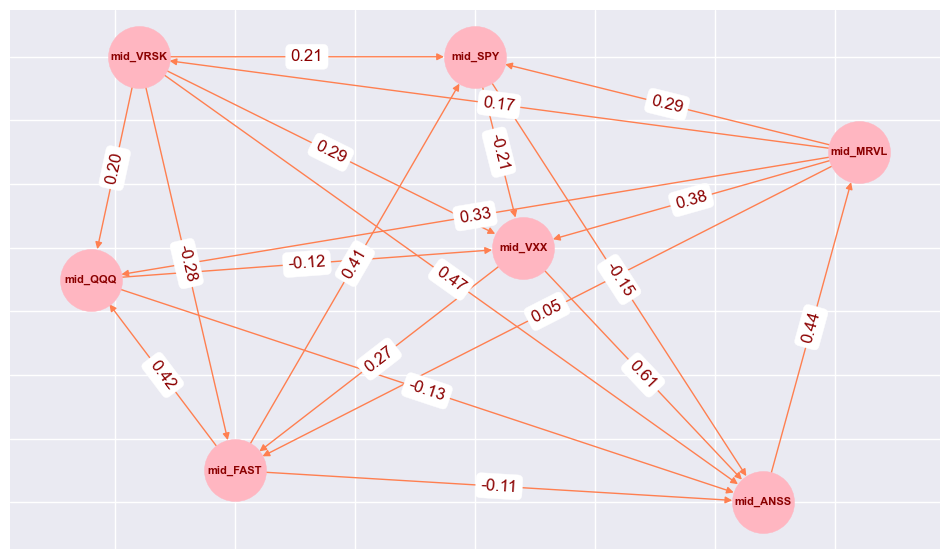

In [135]:
plt.figure(figsize=(12, 7))
node_color = 'lightpink'
edge_color = 'coral'    
font_color = 'darkred' 

fixed_positions_4 = {
    'mid_VXX': [0.1, 0.2],
    'mid_VRSK': [-0.7, 0.8],
    'mid_MRVL': [0.8, 0.5],
    'mid_FAST': [-0.5, -0.5],
    'mid_ANSS': [0.6, -0.6],
    'mid_SPY': [0.0, 0.8],
    'mid_QQQ': [-0.8, 0.1]
}

nx.draw_networkx(G_4, 
                 pos=fixed_positions_4, 
                 with_labels=True, 
                 node_size=2000, 
                 node_color=node_color,
                 edge_color=edge_color,
                 font_size=8, 
                 font_weight='bold',
                 font_color=font_color)

nx.draw_networkx_edge_labels(G_4, 
                             pos=fixed_positions_4, 
                             edge_labels=edge_labels_4, 
                             font_size=12, 
                             font_color='darkred')

plt.show()

Анализ лаговых корреляций mid prices не выявил устойчивых временных сдвигов между инструментами. Максимальные корреляции либо достигаются при нулевом лаге, что указывает на общий рыночный фактор, либо на границах рассматриваемого окна, что является следствием нестационарности уровней цен. Отсутствие воспроизводимости лаговой структуры между днями свидетельствует об отсутствии практической предсказательной ценности лаговых корреляций для данной выборки.

Отвергаем гипотезу о следовании инструментов друг за другом.

### Расчёт автокорреляций

### 30.06

Вычисление автокорреляций: 100%|█████████████████████████████████████████████████████████| 7/7 [11:00<00:00, 94.31s/it]


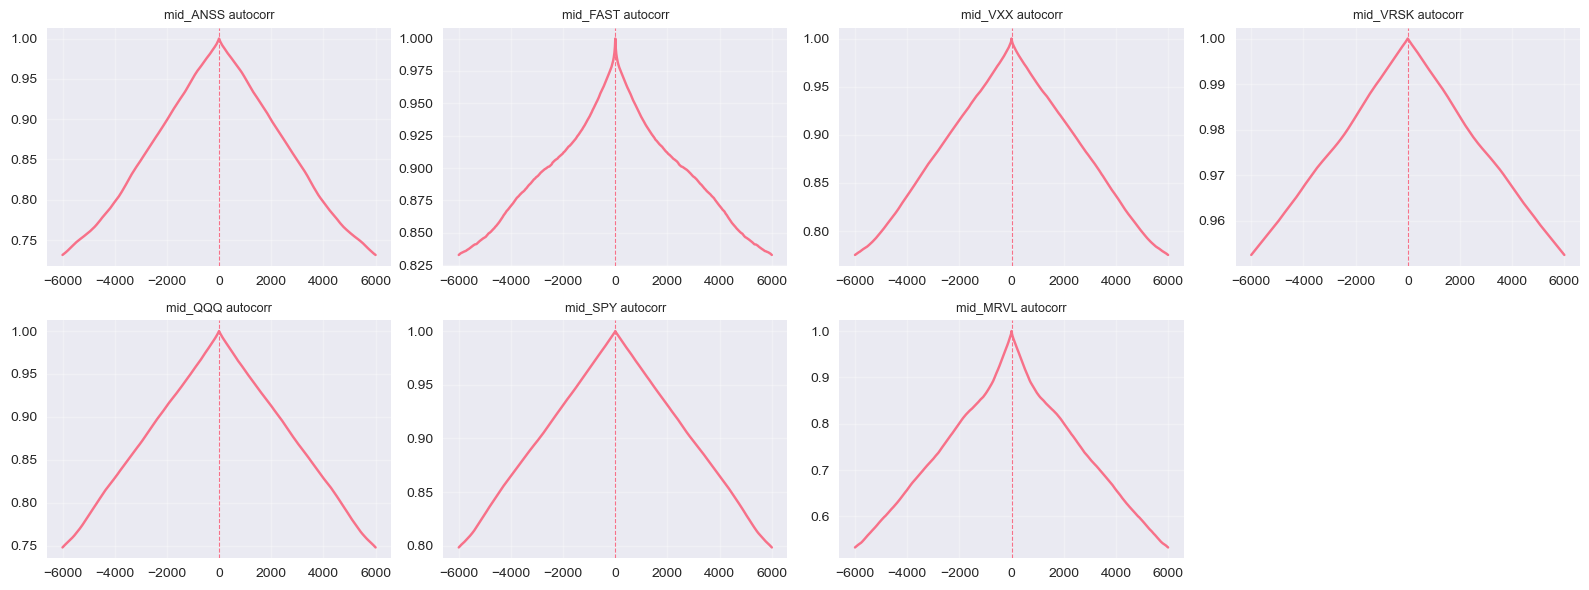

In [136]:
n_1 = len(instruments_mid)

n_1_cols = 4
n_1_rows = math.ceil(n_1 / n_1_cols)

fig, axes = plt.subplots(n_1_rows, n_1_cols, figsize=(4 * n_1_cols, 3 * n_1_rows))
axes = axes.flatten()

results_autocorr_1 = [] 

for idx, inst in enumerate(tqdm(instruments_mid, desc="Вычисление автокорреляций")):
    series = regular_20250630[inst]

    lags, correlations, best_lag, best_correlation = calculate_lagged_correlation(
        series,
        series,
        max_lag_1
    )

    results_autocorr_1.append({
        'Instrument': inst,
        'Best Lag': best_lag,
        'Best Autocorrelation': best_correlation
    })

    ax = axes[idx]
    ax.plot(lags, correlations)
    ax.set_title(f"{inst} autocorr", fontsize=9)
    ax.axvline(0, linestyle="--", linewidth=0.8)
    ax.grid(True, alpha=0.3)


for k in range(n, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()

### 01.07

Вычисление автокорреляций: 100%|█████████████████████████████████████████████████████████| 7/7 [11:10<00:00, 95.73s/it]


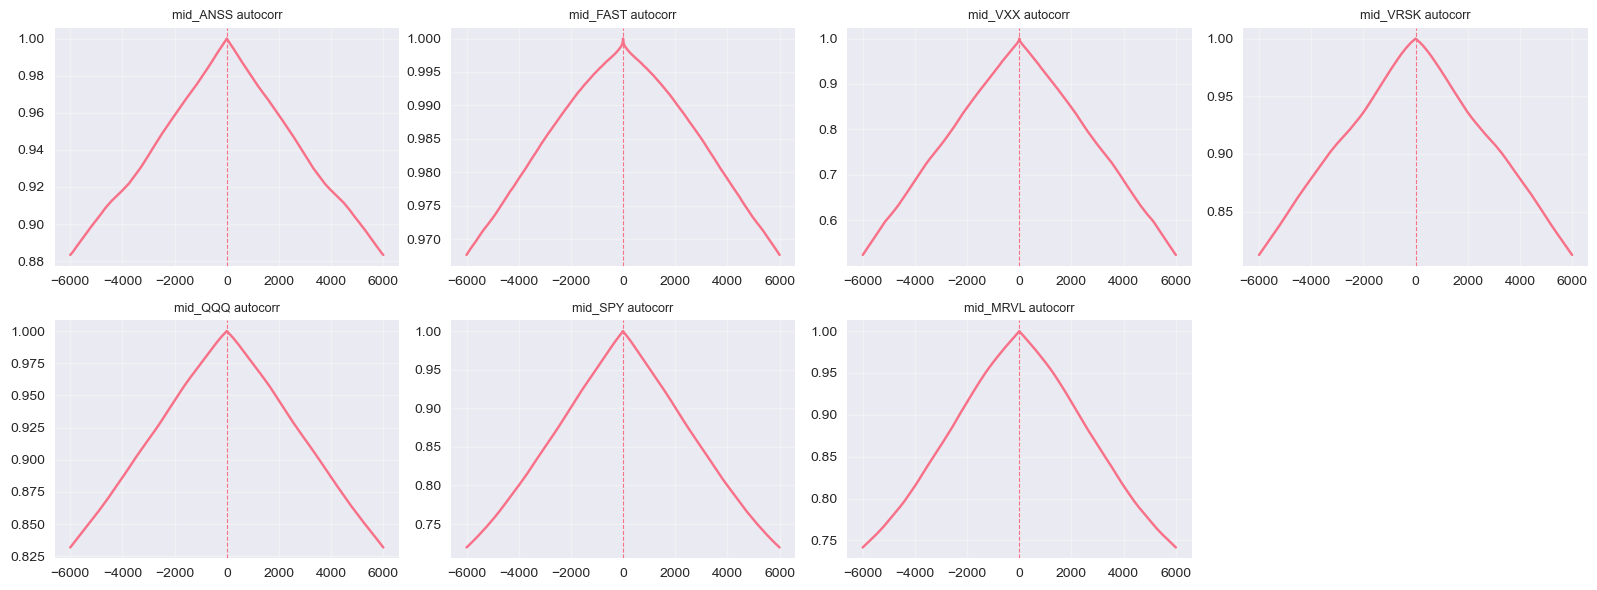

In [138]:
n_1 = len(instruments_mid)

n_1_cols = 4
n_1_rows = math.ceil(n_1 / n_1_cols)

fig, axes = plt.subplots(n_1_rows, n_1_cols, figsize=(4 * n_1_cols, 3 * n_1_rows))
axes = axes.flatten()

results_autocorr_2 = [] 

for idx, inst in enumerate(tqdm(instruments_mid, desc="Вычисление автокорреляций")):
    series = regular_20250701[inst]

    lags, correlations, best_lag, best_correlation = calculate_lagged_correlation(
        series,
        series,
        max_lag_1
    )

    results_autocorr_2.append({
        'Instrument': inst,
        'Best Lag': best_lag,
        'Best Autocorrelation': best_correlation
    })

    ax = axes[idx]
    ax.plot(lags, correlations)
    ax.set_title(f"{inst} autocorr", fontsize=9)
    ax.axvline(0, linestyle="--", linewidth=0.8)
    ax.grid(True, alpha=0.3)


for k in range(n, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()

### 02.07

Вычисление автокорреляций: 100%|█████████████████████████████████████████████████████████| 7/7 [10:59<00:00, 94.28s/it]


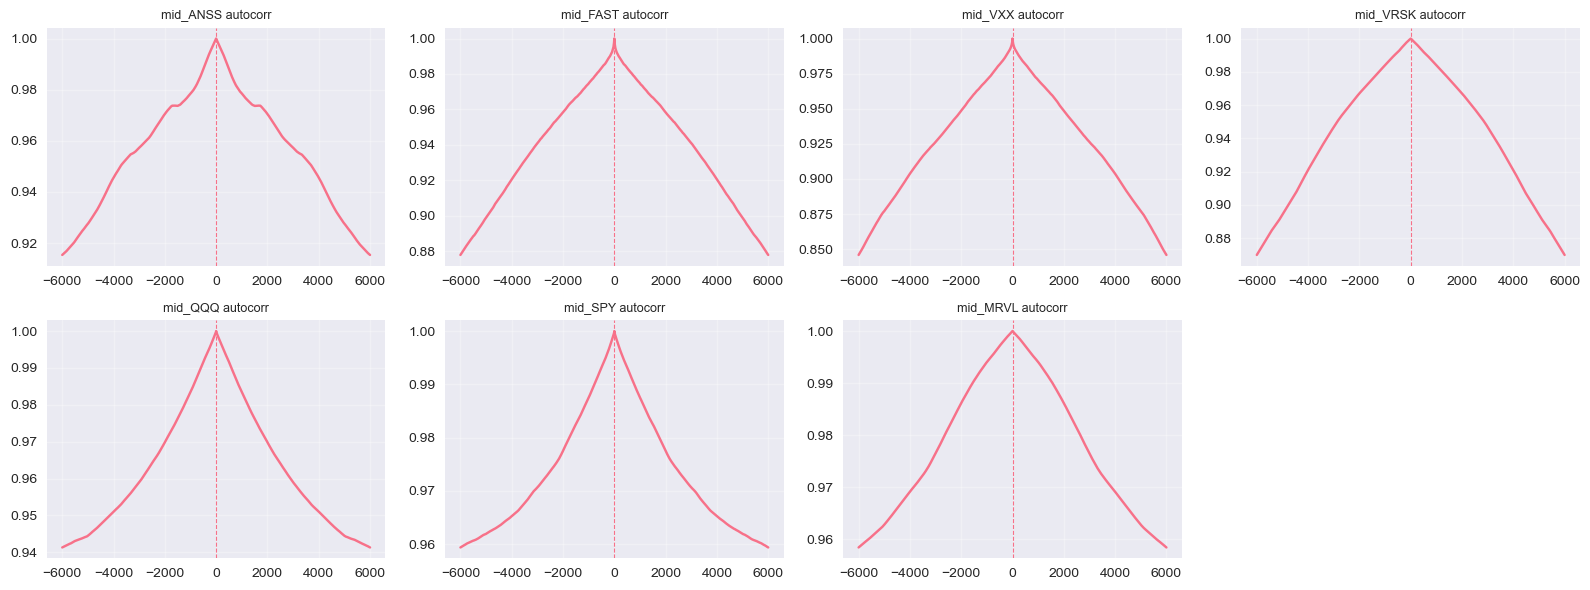

In [140]:
n_1 = len(instruments_mid)

n_1_cols = 4
n_1_rows = math.ceil(n_1 / n_1_cols)

fig, axes = plt.subplots(n_1_rows, n_1_cols, figsize=(4 * n_1_cols, 3 * n_1_rows))
axes = axes.flatten()

results_autocorr_3 = [] 

for idx, inst in enumerate(tqdm(instruments_mid, desc="Вычисление автокорреляций")):
    series = regular_20250702[inst]

    lags, correlations, best_lag, best_correlation = calculate_lagged_correlation(
        series,
        series,
        max_lag_1
    )

    results_autocorr_3.append({
        'Instrument': inst,
        'Best Lag': best_lag,
        'Best Autocorrelation': best_correlation
    })

    ax = axes[idx]
    ax.plot(lags, correlations)
    ax.set_title(f"{inst} autocorr", fontsize=9)
    ax.axvline(0, linestyle="--", linewidth=0.8)
    ax.grid(True, alpha=0.3)


for k in range(n, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()

### 03.07

Вычисление автокорреляций: 100%|█████████████████████████████████████████████████████████| 7/7 [11:23<00:00, 97.71s/it]


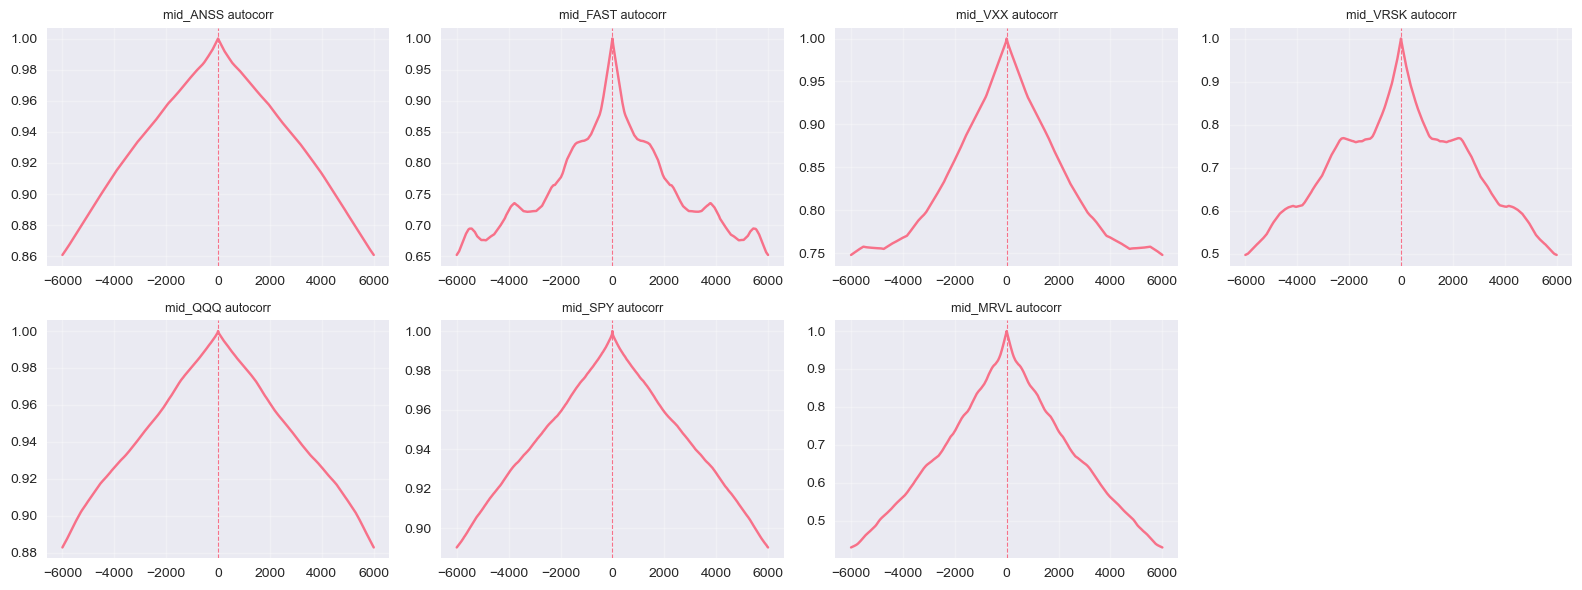

In [141]:
n_1 = len(instruments_mid)

n_1_cols = 4
n_1_rows = math.ceil(n_1 / n_1_cols)

fig, axes = plt.subplots(n_1_rows, n_1_cols, figsize=(4 * n_1_cols, 3 * n_1_rows))
axes = axes.flatten()

results_autocorr_4 = [] 

for idx, inst in enumerate(tqdm(instruments_mid, desc="Вычисление автокорреляций")):
    series = regular_20250703[inst]

    lags, correlations, best_lag, best_correlation = calculate_lagged_correlation(
        series,
        series,
        max_lag_1
    )

    results_autocorr_4.append({
        'Instrument': inst,
        'Best Lag': best_lag,
        'Best Autocorrelation': best_correlation
    })

    ax = axes[idx]
    ax.plot(lags, correlations)
    ax.set_title(f"{inst} autocorr", fontsize=9)
    ax.axvline(0, linestyle="--", linewidth=0.8)
    ax.grid(True, alpha=0.3)


for k in range(n, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()